# Stress FSTs in Python

Here I document some of the results from my dissertation regarding the computation of natural language stress patterns, represented using FSTs. In generative grammar, phonology is seen as a map from an input (underlying representation) to an output (surface representation). These mappings can be studied as mathematical *functions* from the function classes of formal language theory, which are delineated based on their expressive power. 

A stress function maps an underlying string of unstressed syllables to a surface string that is marked for stress in some way. For example, a language with an "initial stress" pattern would looks as follows:

$\sigma\sigma\sigma\sigma \mapsto \acute\sigma\sigma\sigma\sigma$

The initial stress function produces an output with a stressed initial syllable for an input of any length. This is possible because, in these types of languages, the placement of stress is predictable given the length of the word. 

Studying stress functions as FSTs gives us a straightforward way to tackle this question, as the relevant function classes of formal language theory have well-understood automata-theoretic properties. It has long been known that natural language phonology does not exceed the *regular* class in terms of expressive power$^1$. In fact, the vast majority of phonology is *sub*regular i.e. belonging to more restrictive classes$^2$. 

Stress is no exception - some patterns are formally more complex than others, but they are all subject to certain computational restrictions. Not every logically possible stress pattern is attested. Depending on the representational assumptions, no pattern even rises to the complexity of properly regular. What principles, then, separate attested and unattested patterns? This was the central question of my dissertation. The main result was that patterns that are more complex as single functions can be profitably *decomposed* into a series of simpler functions (called "atoms") that - modulo certain restrictions - provide a more restrictive hypothesis for stress typology in general. I walk through some examples below.

<sub>$^1$Johnson (1972), Kaplan and Kay (1994)</sub>

<sub>$^2$Rogers et al. (2013), Heinz (2018)</sub>


*The FSTs in this document were created using the ```transitions``` library: https://github.com/pytransitions/transitions*

### Single stress

The simplest cases of stress are those like initial stress, where a single stress occurs in some bounded window at the word edge. I refer to these as "single stress" patterns. We can create and visualize an FST for intial stress in Python as follows: 

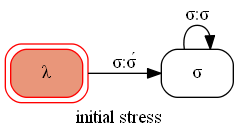

In [4]:
from transitions import Machine                     #to define the machines 
from transitions.extensions import GraphMachine     #to visualize them
from IPython.display import Image                   #to display them here


initial_stress = GraphMachine(states=['λ','σ'],                      #-define the set of states and their labels              
                 transitions = [['σ:σ\u0301', 'λ', 'σ'],             #-define transitions between states, format
                                ['σ:σ', 'σ', 'σ']],                  # is [transition, origin state, destination state]
                 initial='λ', title = "initial stress")              #-define the initial state and (optional) title 

initial_stress.get_graph().draw('initial_stress.png', prog = 'dot')  #create a .png visualization of the machine


Image(filename='initial_stress.png')                                 #display the machine   


The transducer takes in the first syllable it encounters and returns a stressed syllable in the transition to state $\sigma$. From here, no other alterations to the string are made. Note that the structure of the FST means that the only string leading to a change is the empty string $\lambda$. This is a key property of such transducers - only a finite set of strings lead to a transition that provides a non-identity mapping. After this transition is taken, no other changes to the string are made. For initial stress, after a window of one syllable $\sigma$ is seen, no other changes are applied. This is represented in the state label, where $\sigma$ represents this maximal window. This property was first identified and described in my dissertation, where it defines the novel "edge-oriented" (EO) class of functions. 

All single stress patterns are EO. Attested examples place stress at most three syllables from the left or right word edge, meaning the possible patterns are: final, penultimate, antepenultimate, initial, peninitial, and postpeninitial.

### Iterative stress

Another set of stress patterns place stress iteratively throughout the word. Since stress permeates the entire word, these necessarily belong to a function class that is beyond the expressive power of EO. An example pattern comes from Murinbata$^3$, which stresses every other syllable starting with the first, counting from the left: 

$\acute\sigma\sigma, \acute\sigma\sigma\acute\sigma, \acute\sigma\sigma\acute\sigma\sigma, \acute\sigma\sigma\acute\sigma\sigma\acute\sigma, \acute\sigma\sigma\acute\sigma\sigma\acute\sigma\sigma$

As the word size grows, more stresses iterate throughout. The transducer is as follows:

<sub>$^3$Street and Mollinjin (1981)</sub>

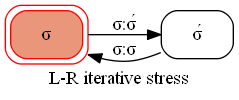

In [8]:
LR_iterative = GraphMachine(states=['σ','σ\u0301'],
                      transitions = [['σ:σ\u0301', 'σ', 'σ\u0301'],
                                     ['σ:σ', 'σ\u0301', 'σ']],
                      initial='σ', title = "L-R iterative stress")
LR_iterative.get_graph().draw('LR_iterative.png', prog = 'dot')

Image(filename='LR_iterative.png')   

The function loops between the two states, alternating between outputting a stressed syllable and an unstressed syllable. This cannot be EO - no local window at a word edge is sufficient, as changes may be applied to the input string for its entire length. For iterative stress, the key component is *output* information - when a stressed syllable is output, the next syllable is unstressed. When an unstressed syllable is output, the next syllable is stressed. This reliance on local information in the output string makes iterative stress *output strictly local* (OSL)$^4$ - the local $k-1$ output suffixes of the string determine the behavior of the function. Note that this cannot be done in the input string - as no stress is placed in the input, the alternation cannot be determined locally with input information. 

<sub>$^4$Chandlee (2014), Chandlee and Heinz (2018)</sub>

### Iterative+

When iteration of stress is the only consideration, OSL is a sufficient hypothesis. However, many iterative patterns are subject to further requirements. A well known example comes from Pintupi$^5$, where stress iterates L-R as in Murinbata, but avoids the final syllable i.e. the pattern observes a "non-finality" requirement:

$\acute\sigma\sigma, \acute\sigma\sigma\sigma, \acute\sigma\sigma\acute\sigma\sigma, \acute\sigma\sigma\acute\sigma\sigma\sigma, \acute\sigma\sigma\acute\sigma\sigma\acute\sigma\sigma$

In forms with an odd number of syllables, the final syllable remains unstressed, even though L-R iteration would normally place stress there. A transducer for Pintupi is as follows:


<sub>$^5$Hansen and Hansen (1969)</sub>

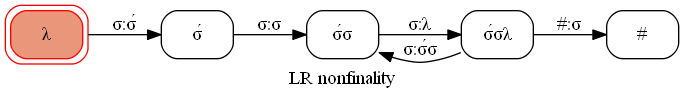

In [10]:
LR_nonfin = GraphMachine(states=['λ', 'σ\u0301','σ\u0301σ','σ\u0301σλ','#'],
                      transitions = [['σ:σ\u0301', 'λ', 'σ\u0301'],
                                     ['σ:σ', 'σ\u0301', 'σ\u0301σ'],
                                     ['σ:λ', 'σ\u0301σ', 'σ\u0301σλ'],
                                     ['σ:σ\u0301σ', 'σ\u0301σλ', 'σ\u0301σ'],
                                     ['#:σ', 'σ\u0301σλ', '#']],
                      initial='λ', title = "LR nonfinality")
LR_nonfin.get_graph().draw('LR_nonfin.png', prog = 'dot')

Image(filename='LR_nonfin.png')   

Whenever an odd-parity syllable is read in the input, the transduction waits, outputting the empty string $\lambda$. This is because, for every odd syllable, the behavior of the function is different if the word is ending or not. If the word continues, the syllable may be stressed. If the word ends, it should be left unstressed, following the non-finality requirement. This means that the function needs to wait and see what comes next. As a result, two of the states represent the same output suffixes, and so the function is not OSL by definition. Instead, it is *subsequential*$^6$. A subsequential function is any one-way function that is computed deterministically on its input. 

<sub>$^6$Schutzenberger (1977), Mohri (1997)</sub>

### Pintupi as function composition

Subsequential functions, despite their subregularity, are quite powerful as a hypothesis for phonological functions. It is also unsatisfying as a hypothesis for iterative stress, as it requires the bisection of iterative typology into OSL and non-OSL subparts. An important question, then, is whether this subsequential analysis of Pintupi-like patterns is appropriate. A major argument of my thesis is that it is not. A more appropriate approach to iterative stress that provides greater restriction and typological unity is to propose that patterns like Pintupi are really the *composition* of simpler functions in sequence, rather than a single more-complex function. 

Specifically, Pintupi is analyzed as the composition of an OSL function that blindly iterates stress, and an EO function that removes the final stress in odd-length forms. These local functions combine to provide the action of the single, more expressive subsequential function. Transducers are as follows:

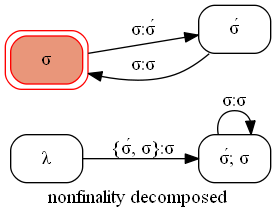

In [13]:
LR_nonfin_decomp = GraphMachine(states=['λ', 'σ\u0301; σ', 'σ','σ\u0301' ],
                      transitions = [['σ:σ\u0301', 'σ', 'σ\u0301'],
                                     ['σ:σ', 'σ\u0301', 'σ'],
                                     ['{σ\u0301, σ}:σ', 'λ', 'σ\u0301; σ'],
                                     ['σ:σ', 'σ\u0301; σ', 'σ\u0301; σ']],
                      initial='σ', title = "nonfinality decomposed")
LR_nonfin_decomp.get_graph().draw('LR_nonfin_decomp.png', prog = 'dot')

Image(filename='LR_nonfin_decomp.png')   




Iterative stress applies left to right first, yielding strings such as this: 

$\acute\sigma\sigma, \acute\sigma\sigma\acute\sigma, \acute\sigma\sigma\acute\sigma\sigma, \acute\sigma\sigma\acute\sigma\sigma\acute\sigma, \acute\sigma\sigma\acute\sigma\sigma\acute\sigma\sigma$

The second, non-finality function then applies right to left on the output of the first function, deleting final stresses when present but otherwise leaving the string unchanged. These two functions combine to provide the appropriate outputs for Pintupi: 

$\acute\sigma\sigma, \acute\sigma\sigma\sigma, \acute\sigma\sigma\acute\sigma\sigma, \acute\sigma\sigma\acute\sigma\sigma\sigma, \acute\sigma\sigma\acute\sigma\sigma\acute\sigma\sigma$






### Bidirectional stress

As another example of a stress pattern that can be described as the interaction of two functions, consider the pattern of Cahuilla$^7$. In Cahuilla, stress iterates in both directions throughout the word, starting at the root boundary, "+":

$\acute\sigma\sigma+\acute\sigma\sigma$

$\sigma\acute\sigma\sigma+\acute\sigma\sigma\acute\sigma $

$\acute\sigma\sigma\acute\sigma\sigma+\acute\sigma\sigma\acute\sigma\sigma $

$\sigma\acute\sigma\sigma\acute\sigma\sigma+\acute\sigma\sigma\acute\sigma\sigma\acute\sigma $

<sub>$^7$Seiler (1977)</sub>

As in Pintupi, stress iterates over the entire length of the word. Unlike Pintupi, stress in Cahuilla must be placed by iterative passes in *both* directions. This is necessary because, for example, stress cannot be placed in the pre-root portion of the word with a left to right function, as it depends on the location of the root boundary. Conversely, stress in the root cannot be placed accurately right to left, as it too depends on the location of the root boundary. A computationally simple analysis is that the surface Cahuilla pattern is the result of two OSL stress iteration functions applying in opposite directions. Consider the following transducers:

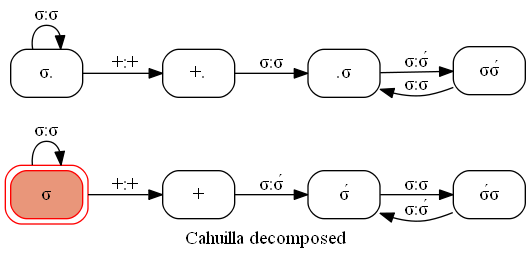

In [14]:
bidirectional_cahuilla = GraphMachine(states=['σ', '+', 'σ\u0301', 'σ\u0301σ', 
                                              'σ.', '+.', '.σ', 'σσ\u0301'],
                      transitions = [['σ:σ', 'σ', 'σ'],
                                     ['+:+', 'σ', '+'],
                                     ['σ:σ\u0301', '+', 'σ\u0301'],
                                     ['σ:σ', 'σ\u0301', 'σ\u0301σ'],
                                     ['σ:σ\u0301', 'σ\u0301σ', 'σ\u0301'],
                                     ['σ:σ', 'σ.', 'σ.'],
                                     ['+:+', 'σ.', '+.'],
                                     ['σ:σ', '+.', '.σ'],
                                     ['σ:σ\u0301', '.σ', 'σσ\u0301'],
                                     ['σ:σ', 'σσ\u0301', '.σ']],
                      initial='σ', title = "Cahuilla decomposed")
bidirectional_cahuilla.get_graph().draw('bidirectional_cahuilla.png', prog = 'dot')

Image(filename='bidirectional_cahuilla.png')  


The first function applies right to left. When it finds the root boundary, it applies iterative stress starting from the second following syllable. The second function applies left to right, applying iterative stress only after the root boundary is encountered. These two functions compose to derive the correct surface pattern for Cahuilla:

|R-L function applies     |             | L-R function applies | 
 |:-----------             | :---------- |:-----------          | 
 | $\sigma\acute\sigma\sigma\acute\sigma\sigma+\sigma\sigma\sigma\sigma\sigma $   |$\mapsto$|$\sigma\acute\sigma\sigma\acute\sigma\sigma+\acute\sigma\sigma\acute\sigma\sigma\acute\sigma $| 
 
 
As the functions do not interact, the order of their application does not actually matter. Analyzing Cahuilla as function composition allows for a deterministic input-output mapping that employs subregular functions, rather than a single, non-deterministic properly regular function.
